In [3]:
using JuMP, Xpress, PyPlot, Random, PyCall

┌ Info: Xpress: Found license file C:\xpressmp\bin\xpauth.xpr
└ @ Xpress C:\Users\rafabench\.julia\packages\Xpress\r6dU3\src\license.jl:42
┌ Info: Xpress: Development license detected.
└ @ Xpress C:\Users\rafabench\.julia\packages\Xpress\r6dU3\src\license.jl:84


In [4]:
xpress = () -> Xpress.Optimizer(OUTPUTLOG = 0)

#1 (generic function with 1 method)

In [5]:
ticker = PyCall.pyimport("matplotlib.ticker");

#### Market clearing

##### Reward Function

$$
\max {R(e)} = \pi^{d} e
$$

##### Market clearing formulation

$$
\begin{array}{ll}
\min & \sum_{j=1}^{J} C_{j} g_{j} \\
\text { s.t. } & \sum_{j=1}^{J} g_{j}=\bar{D}-E_{k} \quad :\pi_{k}^{d}\\
& 0 \leq g_{j} \leq \bar{G}_{j} \quad \forall j
\end{array}
$$

In [10]:
function return_dual_problem(e,G_max,C,d)
    model = Model(xpress)
    @variable(model, G[i = 1:length(G_max)])
    @constraint(model, 0 .<= G .<= G_max)
    @constraint(model,con, sum(G) == d - e)
    @objective(model,Min, sum([C[i]*G[i] for i = 1:length(G_max)]))
    optimize!(model)
    return dual(con)
end

return_dual_problem (generic function with 1 method)

In [25]:
G_max = [30,20,10]
C = [1,2,3]
d = sum(G_max)
e = 0;

In [91]:
C = [20.0,30.0,20.0,15.0,8.0]
G_max = [30.0,25.0,20.0,10.0,5.0]
d = sum(G_max)

90.0

In [110]:
es = collect(0:0.1:d);

In [111]:
@time all_duals = [return_dual_problem(e,G_max,C,d) for e in es];

  3.170117 seconds (2.98 M allocations: 180.977 MiB, 1.49% gc time, 1.90% compilation time)


In [112]:
@time all_revenues = collect(es).*all_duals;

  0.000023 seconds (4 allocations: 14.438 KiB)


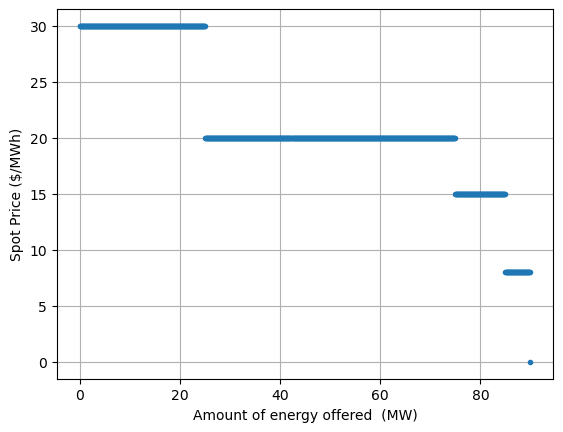

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [113]:
fig = figure(1)
ax = fig.add_subplot(1,1,1)
ax.plot(es,all_duals,".")
ax.set_ylabel("Spot Price (\$/MWh)")
ax.set_xlabel("Amount of energy offered  (MW)")
ax.xaxis.set_major_formatter(ticker.EngFormatter())
grid()
show()

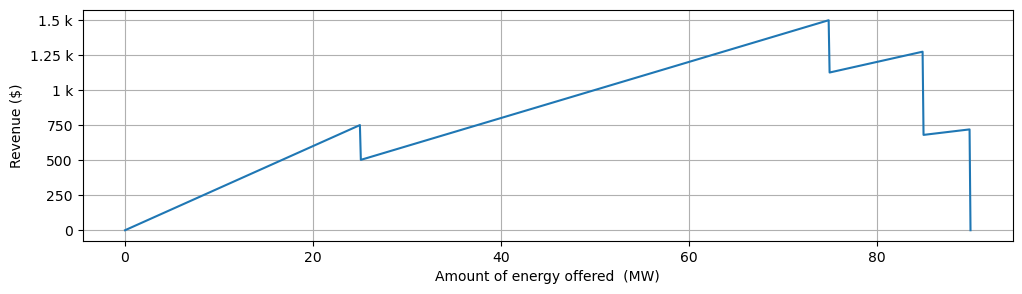

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [114]:
fig = figure(1,figsize=(12,3))
ax = fig.add_subplot(1,1,1)
ax.plot(es,all_revenues)
ax.set_xlabel("Amount of energy offered  (MW)")
ax.set_ylabel("Revenue (\$)")
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.grid()
show()

Build function to get break points of reward function.
In this case: (10,30),(30,60),(60,60)

In [115]:
function generate_points(G_max,C,d)
    GS = sortperm(C)
    sums = cumsum(G_max[GS])
    duals = C[reverse!(GS)]
    points = Tuple{Float64,Float64}[(0.0,0.0)]
    i = 0
    for e in Iterators.reverse(sums)
        excess_energy = d-e
        if excess_energy > 0
            push!(points,(excess_energy,excess_energy*duals[i]))
        end
        i+=1
    end
    push!(points,(d,d*duals[i]))
    return points
end

generate_points (generic function with 1 method)

In [116]:
function get_duals(G_max,C,d)
    GS = sortperm(C)
    sums = cumsum(G_max[GS])
    duals = C[reverse!(GS)]
    eff_duals = []
    i = 0
    for e in Iterators.reverse(sums)
        excess_energy = d-e
        if excess_energy > 0
            push!(eff_duals,duals[i])
        end
        i+=1
    end
    push!(eff_duals,duals[i])
    return eff_duals
end

get_duals (generic function with 1 method)

In [117]:
generate_points(G_max,C,d)

6-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (25.0, 750.0)
 (45.0, 900.0)
 (75.0, 1500.0)
 (85.0, 1275.0)
 (90.0, 720.0)

In [118]:
# https://en.wikibooks.org/wiki/Algorithm_Implementation/Geometry/Convex_hull/Monotone_chain
function cross(o, a, b)
      return (a[1] - o[1]) * (b[2] - o[2]) - (a[2] - o[2]) * (b[1] - o[1])
end

function upper_cvx_hull(points)
    if length(points) <= 1
        return points
    end    
    upper = []
    
    for p in Iterators.reverse(points)
        if length(upper) >= 2
            while cross(upper[end-1], upper[end], p) <= 0
                pop!(upper)
                if length(upper) < 2
                    break
                end
            end
        end
        push!(upper,p)
    end
    return upper
end

upper_cvx_hull (generic function with 1 method)

In [119]:
function concave_revenue_function(G_max,C,d)
    points = generate_points(G_max,C,d)
    points_cvx = upper_cvx_hull(points)
    points_x = [points_cvx[i][1] for i = 1:length(points_cvx)]
    points_y = [points_cvx[i][2] for i = 1:length(points_cvx)]
    return points_x,points_y
end

concave_revenue_function (generic function with 1 method)

In [120]:
function conv_func(m, x, t, points_x, points_y)
    obj = @variable(m, base_name="obj_"*string(t))
    for i in 1:length(points_x)-1
        g_i = (points_y[i+1]-points_y[i])/(points_x[i+1]-points_x[i])
        h_i = (points_y[i]*points_x[i+1]-points_y[i+1]*points_x[i])/(points_x[i+1]-points_x[i])
        @constraint(m, obj <= g_i*x+h_i)
    end
    return obj
end

conv_func (generic function with 1 method)

In [121]:
@time points_ncvx = generate_points(G_max,C,d)
points_ncvx_x = [points_ncvx[i][1] for i = 1:length(points_ncvx)];
points_ncvx_y = [points_ncvx[i][2] for i = 1:length(points_ncvx)];

  0.000017 seconds (8 allocations: 848 bytes)


In [122]:
@time points_x,points_y = concave_revenue_function(G_max,C,d)

  0.175683 seconds (133.47 k allocations: 7.869 MiB, 99.47% compilation time)


([90.0, 85.0, 75.0, 25.0, 0.0], [720.0, 1275.0, 1500.0, 750.0, 0.0])

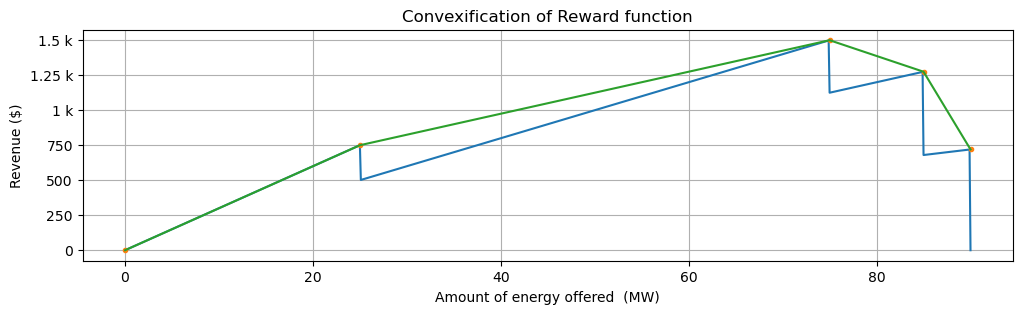

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [123]:
fig = figure(1,figsize=(12,3))
ax = fig.add_subplot(1,1,1)
ax.plot(es,all_revenues)
ax.set_xlabel("Amount of energy offered  (MW)")
ax.set_ylabel("Revenue (\$)")
ax.xaxis.set_major_formatter(ticker.EngFormatter())
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.grid()
plot(points_x,points_y,".")
plot(points_x,points_y)
title("Convexification of Reward function")
show()

#### Model for revenue function

$$
\begin{align}
\beta(D) = &\max \sum_{k = 1}^{K} c_k e_{k} \\
& \quad e = \sum_{k = 1}^{K} e_{k} \quad \forall t \in 1,\dots,T \\
& \quad z_{k} \Delta_k \leq e_{k} \leq z_{k} \Delta_{k+1} \quad \forall t \in 1,\dots,T \quad \forall k \in 1,\dots,K \\
& \quad \Delta_{k+1} = \text{generate_points}(D,g_k) \\
& \quad \sum_{i=1}^{k} z_{k} = 1 \\ 
& \quad z_{k} \in \{0,1\}
\end{align}
$$

In [124]:
@enum INTEGRALITY MIP CONC LP

In [125]:
function reward_function(G_t,C_t,D,e,model; integrality::INTEGRALITY = MIP)
    
    θ = @variable(model)
    if integrality == MIP || integrality == LP
        duals = get_duals(G_t,C_t,D)
        K = length(duals)
        points = generate_points(G_t,C_t,D)
        points_x = [points[i][1] for i = 1:length(points)]
        Delta = points_x
        if integrality == MIP
            z = @variable(model, [1:K], binary=true)
        elseif integrality == LP
            z = @variable(model, [1:K], lower_bound = 0, upper_bound = 1)
        end
        e_seg = @variable(model, [1:K])
        @constraint(model, θ == sum(duals[k]*e_seg[k] for k in 1:K))
        @constraint(model, sum(e_seg) == e)
        @constraint(model, sum(z) == 1)
        for k in 1:K
            @constraint(model, e_seg[k] <= z[k]*Delta[k+1])
            @constraint(model, e_seg[k] >= z[k]*Delta[k])
        end
    elseif integrality == CONC
        points_x,points_y = convexify_pi_function(G_t,C_t,D)
        obj = conv_func(model, e, "1", points_x, points_y)
        @constraint(model, θ == obj)
    end
    
    return θ
end

reward_function (generic function with 1 method)

In [126]:
mip_rev = []
lp_rev = []
conc_rev = []
for e in es
    model1 = Model(xpress)
    θ = reward_function(G_max,C,d,e,model1; integrality = MIP)
    optimize!(model1)
    push!(mip_rev, value(θ))
    
    model2 = Model(xpress)
    θ = reward_function(G_max,C,d,e,model2; integrality = LP)
    optimize!(model2)
    push!(lp_rev, value(θ))
    
    model3 = Model(xpress)
    θ = reward_function(G_max,C,d,e,model3; integrality = CONC)
    optimize!(model3)
    push!(conc_rev, value(θ)) 
end

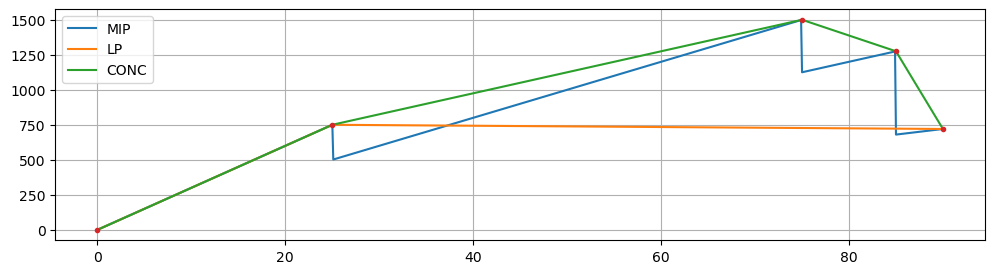

In [128]:
fig = figure(1,figsize=(12,3))
plt.plot(es,mip_rev,label="MIP")
plt.plot(es,lp_rev,label="LP")
plt.plot(es,conc_rev,label="CONC")
plot(points_x,points_y,".")
plt.legend()
plt.grid()